In [1]:
import glob
import uproot
import numpy as np
from sbtveto.model.nn_model import NN
import torch

In [2]:
XYZ =np.load("../SBT/SBT_XYZ.npy")

In [3]:
!ls ml_dataset/

ls: cannot access 'ml_dataset/': No such file or directory


In [4]:
neu_files = glob.glob("../SBT/ml_dataset/*neuDIS*.root")
mu_files = glob.glob("../SBT/ml_dataset/*muDIS*.root")
embg_files = glob.glob("../SBT/ml_dataset/*EMBG*.root")
embg_files = glob.glob("../SBT/mynewsignal/*datafile*.root")

In [5]:
#len(mu_files)

In [6]:
to_concat = []
ys_concat = []
N=0
for i in range(0,202):
    file = uproot.open(neu_files[i])
    x = file['tree;1']['inputmatrix'].array()
    x = np.array(x)
    N += x.shape[0]
    to_concat.append(x)
ys_concat.append(np.ones((N)))
print(N)
N=0
for i in range(0,132):
    file = uproot.open(mu_files[i])
    x = file['tree;1']['inputmatrix'].array()
    x = np.array(x)
    N += x.shape[0]
    to_concat.append(x)
ys_concat.append(2*np.ones((N)))
print(N)
N=0
for i in range(0,12):
    file = uproot.open(embg_files[i])
    x = file['tree;1']['inputmatrix'].array()
    x = np.array(x)
    x = np.hstack( [x[:,:2000], x[:,10000:]])
    N += x.shape[0]
    to_concat.append(x)
print(N)
ys_concat.append(np.zeros((N)))

18089
18103
24000


In [7]:
#X=np.concatenate(to_concat)[:,:-1]
# get rid of last too columns no. ubt cells and  fill weight
X=np.concatenate(to_concat)[:,:-2]

In [8]:
X.shape

(60192, 2003)

In [9]:
X.shape

(60192, 2003)

In [10]:
X[0,:2000].shape

(2000,)

In [11]:
# cut out cells without SBT hits
Xcut = X[np.sum(X[:,:2000],1)>0]

In [12]:
y=np.concatenate(ys_concat)
y = y.astype(int)
ycut = y[np.sum(X[:,:2000],1)>0]

In [13]:
#np.sum(ycut==2)

In [14]:
Xcut[-1]

array([    0.        ,     0.        ,     0.        , ...,
         -24.98344714,    16.62529354, -1652.19906039])

In [15]:
# X =np.hstack([ X  , np.repeat(XYZ[:1,:],X.shape[0],0) - np.expand_dims(X[:,-3],1),
#                np.repeat(XYZ[1:2,:],X.shape[0],0) -  np.expand_dims(X[:,-2],1),
#                np.repeat(XYZ[2:,:],X.shape[0],0) -  np.expand_dims(X[:,-1],1)] )

In [16]:
# X =np.hstack([ X  , np.repeat(XYZ[:1,:],X.shape[0],0),
#               np.repeat(XYZ[1:2,:],X.shape[0],0) ,
#               np.repeat(XYZ[2:,:],X.shape[0],0) ] )

In [17]:
from sklearn.model_selection import train_test_split
import torch
from sklearn.preprocessing import RobustScaler, StandardScaler, MinMaxScaler
import joblib

In [18]:
Xcut.shape

(53227, 2003)

In [19]:
#y.shapsc

In [20]:
Xcut.shape

(53227, 2003)

In [21]:
scaler = RobustScaler()
#scaler = StandardScaler()
#scaler = MinMaxScaler()
scaler.fit(Xcut)

RobustScaler()

In [22]:
Xcut = scaler.transform(Xcut)

In [23]:
X.shape

(60192, 2003)

In [24]:
#X

In [25]:
np.std(X[:,1])

np.float64(0.00459877786824326)

In [26]:
scaler.scale_

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       9.60094278e+01, 5.21120773e+01, 4.05713963e+03])

In [27]:
joblib.dump(scaler, 'robust_scaler.pkl')

['robust_scaler.pkl']

In [28]:
scaler.get_params()

{'copy': True,
 'quantile_range': (25.0, 75.0),
 'unit_variance': False,
 'with_centering': True,
 'with_scaling': True}

In [29]:
scaler.scale_

array([1.00000000e+00, 1.00000000e+00, 1.00000000e+00, ...,
       9.60094278e+01, 5.21120773e+01, 4.05713963e+03])

In [30]:
import json

scaler_params = {
     'center_': scaler.center_.tolist(),
     'scale_': scaler.scale_.tolist()
 }

with open('data/robust_scaler.json', 'w') as f:
    json.dump(scaler_params, f)

In [31]:
X = torch.tensor(Xcut, dtype=torch.float)
ycut= torch.tensor(ycut, dtype=torch.int64)

In [32]:
X.shape

torch.Size([53227, 2003])

In [33]:
torch.sum(X[:,-2])

tensor(370.4648)

In [34]:
ycut.shape

torch.Size([53227])

In [35]:
X_train, X_test, y_train, y_test = train_test_split(X,ycut ,test_size= 0.2)

In [36]:
X[1,-3]

tensor(0.3305)

In [37]:
X.shape

torch.Size([53227, 2003])

In [38]:
y_train.shape

torch.Size([42581])

In [39]:
import torch
from torch_geometric.loader import DataLoader

traindata = torch.utils.data.TensorDataset(X_train,y_train)
train_loader = DataLoader(traindata, batch_size=32, shuffle=True)

In [40]:

testdata = torch.utils.data.TensorDataset(X_test, y_test)
val_loader = DataLoader(testdata, batch_size=32, shuffle=True )

In [41]:
X_test.shape

torch.Size([10646, 2003])

In [42]:
network = NN(2003,3,[32,32,32,16,8], dropout=0)

In [43]:
for b in train_loader:
    print(b)
    network(b[0])
    break

[tensor([[ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.7282e-01,
         -9.4651e-02, -2.1793e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -6.4115e-01,
         -5.8252e+00,  4.4641e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -1.7912e+00,
          6.9287e-01,  1.0668e-01],
        ...,
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ..., -8.1948e-01,
         -8.0873e-01,  3.3477e-01],
        [ 0.0000e+00,  0.0000e+00,  0.0000e+00,  ...,  7.5921e-02,
          1.0356e-01, -7.1194e-01],
        [ 0.0000e+00,  4.9352e-04,  0.0000e+00,  ..., -4.0896e-01,
          4.0687e-01, -7.1027e-01]]), tensor([0, 1, 2, 1, 0, 0, 2, 1, 1, 1, 1, 1, 0, 0, 2, 0, 0, 0, 1, 2, 0, 0, 2, 1,
        1, 0, 1, 2, 0, 0, 1, 1])]


In [44]:
network

NN(
  (_layers): ModuleList(
    (0): Linear(in_features=2003, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (_batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_dropout): Dropout(p=0, inplace=False)
  (_output_layer): Linear(in_features=8, out_features=3, bias=True)
)

In [45]:
from torch import nn


In [46]:
device='cuda'

model = network
model.cuda()

# Loss and optimizer
criterion = torch.nn.BCEWithLogitsLoss()
optimizer = torch.optim.Adam(model.parameters())

from datetime import datetime

In [47]:
criterion = nn.CrossEntropyLoss()

In [48]:
model = model.cuda()

epoch_log = []
loss_log = []
val_loss_log = []
accuracy_log = []
val_accuracy_log = []

criterion = nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

In [49]:
epochs = 10
    

for epoch in range(epochs):  
    print(f'Epoch: {epoch+1}')

    running_loss = 0.0
    running_correct = 0.0 
    running_total = 0.0
    actual_loss = 0.0
    # loop over training batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # compute loss
        loss =  criterion(outputs, labels)

        # backward propagation
        loss.backward()
        optimizer.step()

        # add batch loss to running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim = 1)

        running_total += labels.size(0)

        running_correct += (predicted == labels).sum().item()

        if i % 400 == 399:    
            valcorrect = 0 
            valtotal = 0 
            running_val_loss = 0

            with torch.no_grad():
                for data in val_loader:

                    # apply model to validation batch
                    images, labels = data

                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)

                    val_loss =  criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, dim = 1)

                    valtotal += labels.size(0)

                    valcorrect += (predicted == labels).sum().item()
                    
                    running_val_loss += val_loss.item() 

                val_accuracy = 100 * valcorrect / valtotal
                accuracy = 100 * running_correct / running_total
                epoch_num = epoch + 1
                
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Train Accuracy = {accuracy:.3f}%')
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Val Accuracy = {val_accuracy:.3f}%')
                

    actual_loss = running_loss / running_total
    actual_val_loss = running_val_loss / valtotal
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    val_loss_log.append(actual_val_loss)
    accuracy_log.append(accuracy)
    val_accuracy_log.append(val_accuracy)
    print('\n')
    print(f"Epoch {epoch_num} summary stats:")
    print(f'Train Loss: {actual_loss:.4f}, Train Accuracy = {accuracy:.3f}%')
    print(f'Val Loss: {actual_val_loss:.4f}, Val Accuracy = {val_accuracy:.3f}%')
    print('\n')
    print('\n')

Epoch: 1
Epoch: 1, Mini-Batches Completed: 400 Train Accuracy = 84.328%
Epoch: 1, Mini-Batches Completed: 400 Val Accuracy = 88.691%
Epoch: 1, Mini-Batches Completed: 800 Train Accuracy = 86.910%
Epoch: 1, Mini-Batches Completed: 800 Val Accuracy = 90.701%
Epoch: 1, Mini-Batches Completed: 1200 Train Accuracy = 88.034%
Epoch: 1, Mini-Batches Completed: 1200 Val Accuracy = 90.813%


Epoch 1 summary stats:
Train Loss: 0.0104, Train Accuracy = 88.034%
Val Loss: 0.0081, Val Accuracy = 90.813%




Epoch: 2
Epoch: 2, Mini-Batches Completed: 400 Train Accuracy = 91.859%
Epoch: 2, Mini-Batches Completed: 400 Val Accuracy = 91.762%
Epoch: 2, Mini-Batches Completed: 800 Train Accuracy = 91.793%
Epoch: 2, Mini-Batches Completed: 800 Val Accuracy = 91.396%
Epoch: 2, Mini-Batches Completed: 1200 Train Accuracy = 91.927%
Epoch: 2, Mini-Batches Completed: 1200 Val Accuracy = 91.612%


Epoch 2 summary stats:
Train Loss: 0.0070, Train Accuracy = 91.927%
Val Loss: 0.0073, Val Accuracy = 91.612%




Epoc

In [50]:
X.shape

torch.Size([53227, 2003])

In [51]:
optimizer = torch.optim.Adam(model.parameters(), lr=0.0001)

In [52]:
epochs = 2
    

for epoch in range(epochs):  
    print(f'Epoch: {epoch+1}')

    running_loss = 0.0
    running_correct = 0.0 
    running_total = 0.0
    actual_loss = 0.0
    # loop over training batches
    for i, data in enumerate(train_loader, 0):
        inputs, labels = data

        inputs = inputs.to(device)
        labels = labels.to(device)

        # clear gradients
        optimizer.zero_grad()

        # forward propagation
        outputs = model(inputs)

        # compute loss
        loss =  criterion(outputs, labels)

        # backward propagation
        loss.backward()
        optimizer.step()

        # add batch loss to running loss
        running_loss += loss.item()
        _, predicted = torch.max(outputs.data, dim = 1)

        running_total += labels.size(0)

        running_correct += (predicted == labels).sum().item()

        if i % 400 == 399:    
            valcorrect = 0 
            valtotal = 0 
            running_val_loss = 0

            with torch.no_grad():
                for data in val_loader:

                    # apply model to validation batch
                    images, labels = data

                    images = images.to(device)
                    labels = labels.to(device)

                    outputs = model(images)

                    val_loss =  criterion(outputs, labels)

                    _, predicted = torch.max(outputs.data, dim = 1)

                    valtotal += labels.size(0)

                    valcorrect += (predicted == labels).sum().item()
                    
                    running_val_loss += val_loss.item() 

                val_accuracy = 100 * valcorrect / valtotal
                accuracy = 100 * running_correct / running_total
                epoch_num = epoch + 1
                
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Train Accuracy = {accuracy:.3f}%')
                print(f'Epoch: {epoch_num}, Mini-Batches Completed: {(i+1)} Val Accuracy = {val_accuracy:.3f}%')
                

    actual_loss = running_loss / running_total
    actual_val_loss = running_val_loss / valtotal
    epoch_log.append(epoch_num)
    loss_log.append(actual_loss)
    val_loss_log.append(actual_val_loss)
    accuracy_log.append(accuracy)
    val_accuracy_log.append(val_accuracy)
    print('\n')
    print(f"Epoch {epoch_num} summary stats:")
    print(f'Train Loss: {actual_loss:.4f}, Train Accuracy = {accuracy:.3f}%')
    print(f'Val Loss: {actual_val_loss:.4f}, Val Accuracy = {val_accuracy:.3f}%')
    print('\n')
    print('\n')

Epoch: 1
Epoch: 1, Mini-Batches Completed: 400 Train Accuracy = 96.805%
Epoch: 1, Mini-Batches Completed: 400 Val Accuracy = 93.068%
Epoch: 1, Mini-Batches Completed: 800 Train Accuracy = 96.914%
Epoch: 1, Mini-Batches Completed: 800 Val Accuracy = 92.936%
Epoch: 1, Mini-Batches Completed: 1200 Train Accuracy = 96.924%
Epoch: 1, Mini-Batches Completed: 1200 Val Accuracy = 93.134%


Epoch 1 summary stats:
Train Loss: 0.0028, Train Accuracy = 96.924%
Val Loss: 0.0070, Val Accuracy = 93.134%




Epoch: 2
Epoch: 2, Mini-Batches Completed: 400 Train Accuracy = 97.008%
Epoch: 2, Mini-Batches Completed: 400 Val Accuracy = 92.936%
Epoch: 2, Mini-Batches Completed: 800 Train Accuracy = 97.070%
Epoch: 2, Mini-Batches Completed: 800 Val Accuracy = 93.228%
Epoch: 2, Mini-Batches Completed: 1200 Train Accuracy = 97.234%
Epoch: 2, Mini-Batches Completed: 1200 Val Accuracy = 93.171%


Epoch 2 summary stats:
Train Loss: 0.0025, Train Accuracy = 97.234%
Val Loss: 0.0072, Val Accuracy = 93.171%






In [53]:
!ls

apply_gnn.py
apply_nn.py
CM_GNN_CE_val_newdataset_new_6block.png
CM_NN_CE_val_new.png
CM_NN_CE_val_new_Sep20.png
data
GNN_global.ipynb
GNN_xyz_in_global.ipynb
NN.ipynb
nnveto_implementation.py
plots
README.md
robust_scaler.pkl
SBT_vacuum_multiclass_4block_GNN_new.pt
SBT_vacuum_multiclass_6block_GNN_new.pt
sbtveto
SBTveto_vacuum_multiclass_NN_SBT_E_signal_xyz.pth
shipVeto.py


In [54]:
for b in val_loader:
    break

In [55]:
b[0].shape

torch.Size([32, 2003])

In [56]:
#model_scripted = torch.jit.script(model) # Export to TorchScript
#model_scripted.save(‘SBTveto_vacuum_multiclass_NN_scripted.pt’) # Save

In [58]:
torch.save(model.state_dict(), 'SBTveto_vacuum_multiclass_NN_SBT_E_signal_xyz.pth')

In [59]:
scaler_loaded = joblib.load('robust_scaler.pkl')

In [78]:
model.load_state_dict(torch.load('SBTveto_vacuum_multiclass_NN.pth', weights_only=True))
model.eval()

NN(
  (_layers): ModuleList(
    (0): Linear(in_features=8004, out_features=32, bias=True)
    (1): Linear(in_features=32, out_features=32, bias=True)
    (2): Linear(in_features=32, out_features=16, bias=True)
    (3): Linear(in_features=16, out_features=8, bias=True)
  )
  (_batch_norms): ModuleList(
    (0-1): 2 x BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (3): BatchNorm1d(8, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  )
  (_dropout): Dropout(p=0, inplace=False)
  (_output_layer): Linear(in_features=8, out_features=3, bias=True)
)

In [96]:
def nn_output(model, data, sbt_xyz, scalar, device="cuda"):
    X=np.hstack([ data  , np.repeat(XYZ[:1,:],data.shape[0],0),
              np.repeat(XYZ[1:2,:],data.shape[0],0),
              np.repeat(XYZ[2:,:],data.shape[0],0)])
    X = scalar.transform(X)
    X = torch.tensor(X, dtype =torch.float32 ).to(device)
    output = model(X) 
    sbt_decision = (torch.max(output, dim = 1).indices == 0)
    return output, sbt_decision




In [58]:
def nn_output2(model, data,  scalar, device="cuda"):
    X = scalar.transform(X)
    X = torch.tensor(X, dtype =torch.float32 ).to(device)
    output = model(X) 
    sbt_decision = (torch.max(output, dim = 1).indices == 0)
    return output, sbt_decision

In [65]:
X.shape

(54192, 2004)

In [66]:
X.shape

(54192, 2004)

In [67]:
X_2.shape

(32, 2004)

In [71]:
b[0].shape

torch.Size([32, 8004])

In [72]:
XYZ

array([[ 2.32880000e+01, -2.32880000e+01,  1.77635684e-15, ...,
        -2.15464000e+02,  2.15464000e+02, -2.15464000e+02],
       [ 1.44426250e+02, -1.44426250e+02,  1.44426250e+02, ...,
        -3.07570920e+02, -3.07570920e+02,  3.07570920e+02],
       [-2.43725000e+03, -2.43725000e+03, -2.43725000e+03, ...,
         2.44275000e+03,  2.44275000e+03,  2.44275000e+03]])

In [101]:
nn_output(model, X_2, XYZ, scaler_loaded )

(tensor([[-5.0401,  3.5098, -3.7395],
         [ 1.3470,  2.8906, -5.4627]], device='cuda:0',
        grad_fn=<AddmmBackward0>),
 tensor([False, False], device='cuda:0'))

In [99]:
nn_output()

TypeError: nn_output() missing 4 required positional arguments: 'model', 'X', 'xyz', and 'scalar'

In [60]:
ypreds=[]
ys =[]


In [61]:
for data in val_loader:

    # apply model to validation batch
    images, labels = data

    images = images.to(device)
    labels = labels.to(device)

    outputs = model(images)

    val_loss =  criterion(outputs, labels)

    _, predicted = torch.max(outputs.data, dim = 1)
    ys.append(labels.cpu().detach().numpy())
    ypreds.append(predicted.cpu().detach().numpy())

In [62]:
ypred = np.concatenate(ypreds)
true = np.concatenate(ys)

In [63]:
from sklearn import metrics
import numpy as np
import matplotlib.pyplot as plt

In [64]:
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, ypred)

In [65]:
cm

array([[3569,   28,   23],
       [  33, 3181,  268],
       [  26,  327, 3191]])

In [66]:
cm

array([[3569,   28,   23],
       [  33, 3181,  268],
       [  26,  327, 3191]])

In [67]:
preds=ypred

In [68]:
np.sum(preds == true)/true.shape[0]

np.float64(0.9337779447679879)

In [69]:
labels=['signal',r'$\nu$-DIS', r'$\mu$-DIS']
from sklearn.metrics import confusion_matrix

cm = confusion_matrix(true, preds)

In [70]:
cmnew =cm/np.expand_dims(np.sum(cm,1),1)

In [71]:
def plot_errorband(x, y, y_err, label, color):
    plt.plot(x, y, color=color, ls='solid', label=label)
    plt.fill_between(x, y_err[0],y_err[1], color=color, alpha=0.3, lw=0)
   
    
def init_thesis_plot_style():
    my_rc_params = {
        "xtick.direction": "in",
        "xtick.major.size": 8.0,
        "xtick.minor.size": 4.0,
        "xtick.minor.visible": True,
        "xtick.major.width": 1.2,
        "xtick.minor.width": 0.9,
        "ytick.direction": "in",
        "ytick.major.size": 8.0,
        "ytick.minor.size": 4.0,
        "ytick.minor.visible": True,
        "ytick.major.width": 1.2,
        "ytick.minor.width": 0.9,
        "errorbar.capsize": 2,
        "axes.linewidth": 1.2,
        # "font.familiy": "serif",
        "font.size": 14,
        "axes.grid": False,
        "ytick.right": True,
        "xtick.top": True
    }
    return(my_rc_params)
class Tango(object):
    scarlet_red_light = '#ef2929'
    scarlet_red = '#cc0000'
    scarlet_red_dark = '#a40000'

    aluminium_light = '#eeeeec'
    aluminium = '#d3d7cf'
    aluminium_dark = '#babdb6'

    butter_light = '#fce94f'
    butter = '#edd400'
    butter_dark = '#c4a000'

    chameleon_light = '#8ae234'
    chameleon = '#73d216'
    chameleon_dark = '#4e9a06'

    orange_light = '#fcaf3e'
    orange = '#f57900'
    orange_dark = '#ce5c00'

    chocolate_light = '#e9b96e'
    chocolate = '#c17d11'
    chocolate_dark = '#8f5902'

    sky_blue_light = '#729fcf'
    sky_blue = '#3465a4'
    sky_blue_dark = '#204a87'

    plum_light = '#ad7fa8'
    plum = '#75507b'
    plum_dark = '#5c3566'

    slate_light = '#888a85'
    slate = '#555753'
    slate_dark = '#2e3436'

init_thesis_plot_style()
plt.rcParams.update(init_thesis_plot_style())

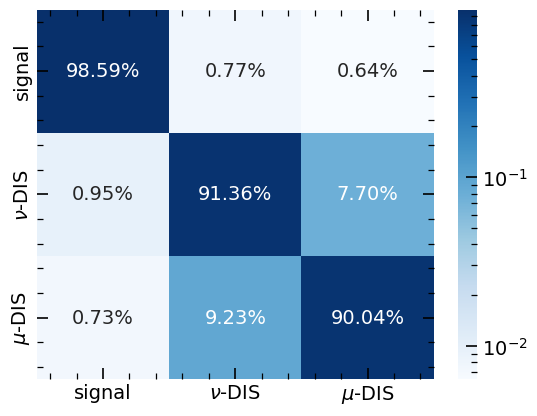

In [72]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.heatmap(cmnew, 
            fmt='.2%', norm= LogNorm(),
            annot=True,  xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.savefig('CM_NN_CE_val_new_Sep20.png')

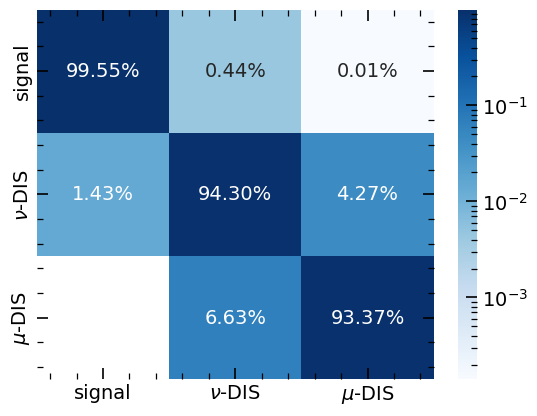

In [70]:
import seaborn as sns
from matplotlib.colors import LogNorm
sns.heatmap(cmnew, 
            fmt='.2%', norm= LogNorm(),
            annot=True,  xticklabels=labels, yticklabels=labels, cmap='Blues')
plt.savefig('CM_NN_CE_val.png')

In [71]:
np.sum(ypred[true==2]==2)/len(ypred[true==2])

0.9337039045553145

In [74]:
np.sum(ypred[true==2]==0)/len(ypred[true==2])

0.0

In [73]:
np.sum(ypred[true==2]==1)/len(ypred[true==2])

0.06629609544468547

In [51]:
np.sum(ypred[true==2]==0)

10

In [47]:
np.sum(ypred[true==2]==0)/len(ypred[true==2])

0.0053590568060021436

In [48]:
len(ypred[true==2])

1866

In [49]:
labels=['neuDIS', 'muDIS', 'sig']

<Axes: >

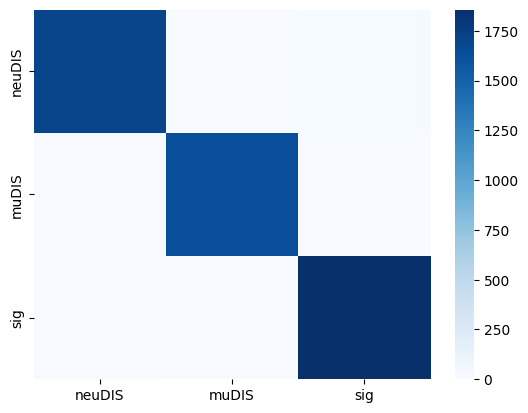

In [50]:
import seaborn as sns
sns.heatmap(cm, 
            fmt='.2%', xticklabels=labels, yticklabels=labels, cmap='Blues')

In [130]:
!ls ml_dataset/*.ipynb

ls: cannot access 'ml_dataset/*.ipynb': No such file or directory


In [131]:
!ls ml_dataset

datafile_EMBG_0_19.root        datasets
datafile_EMBG_1000_154.root    pathtodata_EMBG_0_19.csv
datafile_EMBG_1001_257.root    pathtodata_EMBG_1000_154.csv
datafile_EMBG_1002_62.root     pathtodata_EMBG_1001_257.csv
datafile_EMBG_1003_37.root     pathtodata_EMBG_1002_62.csv
datafile_EMBG_1004_10.root     pathtodata_EMBG_1003_37.csv
datafile_EMBG_1005_6.root      pathtodata_EMBG_1004_10.csv
datafile_EMBG_100_57.root      pathtodata_EMBG_1005_6.csv
datafile_EMBG_1006_35.root     pathtodata_EMBG_100_57.csv
datafile_EMBG_1007_68.root     pathtodata_EMBG_1006_35.csv
datafile_EMBG_1008_5.root      pathtodata_EMBG_1007_68.csv
datafile_EMBG_1009_170.root    pathtodata_EMBG_1008_5.csv
datafile_EMBG_1010_12.root     pathtodata_EMBG_1009_170.csv
datafile_EMBG_1011_186.root    pathtodata_EMBG_1010_12.csv
datafile_EMBG_1012_18.root     pathtodata_EMBG_1011_186.csv
datafile_EMBG_1013_271.root    pathtodata_EMBG_1012_18.csv
datafile_EMBG_101_36.root      pathtodata_EMBG_1013_271.csv
datafile_EMBG_101